<a href="https://colab.research.google.com/github/Ramyavijaykumar/ANN_HeartSoundClassification_LSTMRNN/blob/main/LSTM_HEARTBEAT_HARMONICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import lazy_loader as lazy
import soundfile as sf
import audioread



Populating the interactive namespace from numpy and matplotlib


In [2]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.14.0
keras version:  2.14.0


In [5]:
# parent folder of sound files
INPUT_DIR = "/content/heartsound/input"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12

In [7]:
!pwd
!ls -all "/content/heartsound/input"

/content
total 84
drwxr-xr-x 5 root root  4096 Nov  1 05:04 .
drwxr-xr-x 4 root root  4096 Nov  1 05:03 ..
drwxr-xr-x 2 root root  4096 Nov  1 05:03 .ipynb_checkpoints
drwxr-xr-x 2 root root  4096 Nov  1 05:04 set_app
-rw-r--r-- 1 root root  2397 Nov  1 05:03 set_app.csv
-rw-r--r-- 1 root root  9919 Nov  1 05:03 set_app_timing.csv
drwxr-xr-x 2 root root  4096 Nov  1 05:04 set_clinic
-rw-r--r-- 1 root root 48705 Nov  1 05:03 set_clinic.csv


In [12]:
set_app=pd.read_csv(INPUT_DIR+"/set_app.csv")
set_app.head()

,dataset,fname,label,sublabel
0,app,set_app/normal__201108011118.wav,normal,NaN
1,app,set_app/normal__201108011115.wav,normal,NaN
2,app,set_app/normal__201108011114.wav,normal,NaN
3,app,set_app/normal__201108011112.wav,normal,NaN
4,app,set_app/normal__201106221450.wav,normal,NaN


In [14]:
set_app_timing=pd.read_csv(INPUT_DIR+"/set_app_timing.csv")
set_app_timing.head()

,fname,cycle,sound,location
0,set_app/normal__201108011118.wav,1,S1,7591
1,set_app/normal__201108011118.wav,1,S2,20496
2,set_app/normal__201108011118.wav,2,S1,37197
3,set_app/normal__201108011118.wav,2,S2,50862
4,set_app/normal__201108011118.wav,3,S1,66803


In [13]:
set_clinic=pd.read_csv(INPUT_DIR+"/set_clinic.csv")
set_clinic.head()

,dataset,fname,label,sublabel
0,clinic,set_clinic/Btraining_extrastole_127_1306764300...,extrastole,NaN
1,clinic,set_clinic/Btraining_extrastole_128_1306344005...,extrastole,NaN
2,clinic,set_clinic/Btraining_extrastole_130_1306347376...,extrastole,NaN
3,clinic,set_clinic/Btraining_extrastole_134_1306428161...,extrastole,NaN
4,clinic,set_clinic/Btraining_extrastole_138_1306762146...,extrastole,NaN


In [17]:
frames = [set_app, set_clinic]
train_ab=pd.concat(frames)
train_ab.describe()

,dataset,fname,label,sublabel
count,709,709,501,149
unique,2,709,5,2
top,clinic,set_app/normal__201108011118.wav,normal,noisynormal
freq,656,1,333,120


In [18]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 709   Number of classes= 6
['normal' 'murmur' 'extrahls' 'artifact' nan 'extrastole']


Min samples per category =  8
Max samples per category =  333


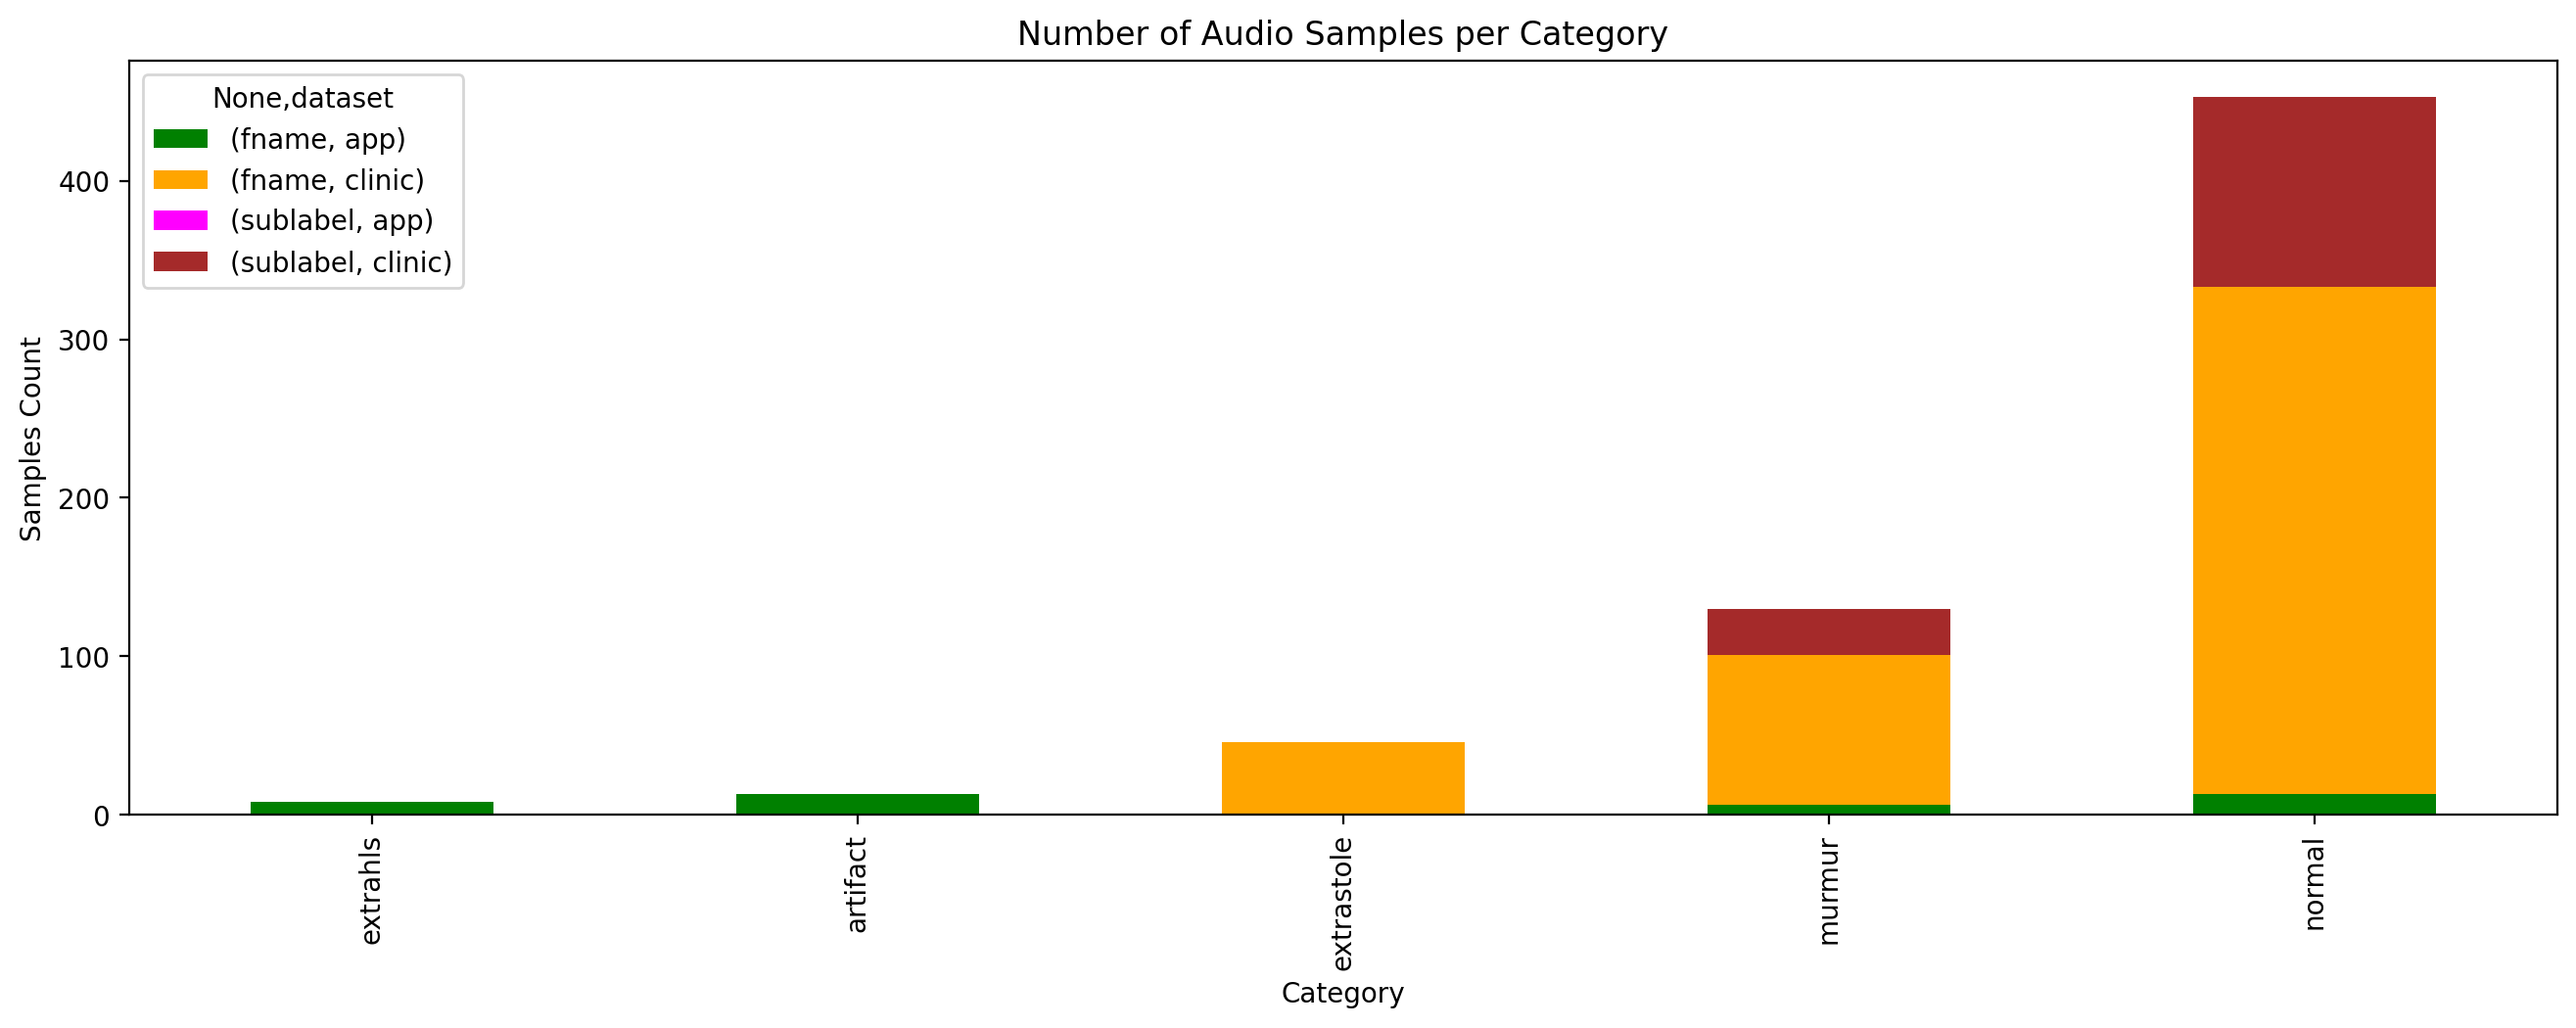

In [34]:
import matplotlib.pyplot as plt

# Define custom colors for each category
colors = ['green', 'orange', 'magenta', 'brown', 'orange', 'cyan', 'magenta', 'brown', 'gray', 'pink']

# Visualize data distribution by category
category_group = train_ab.groupby(['label', 'dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
    .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16, 5), color=colors)

plot.set_xlabel("Category")
plot.set_ylabel("Samples Count")

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

plt.show()

Category

In [38]:
#Normal
normal_file=INPUT_DIR+"/set_app/normal__201106111136.wav"

In [39]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file)

In [40]:
# Load use wave
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [41]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


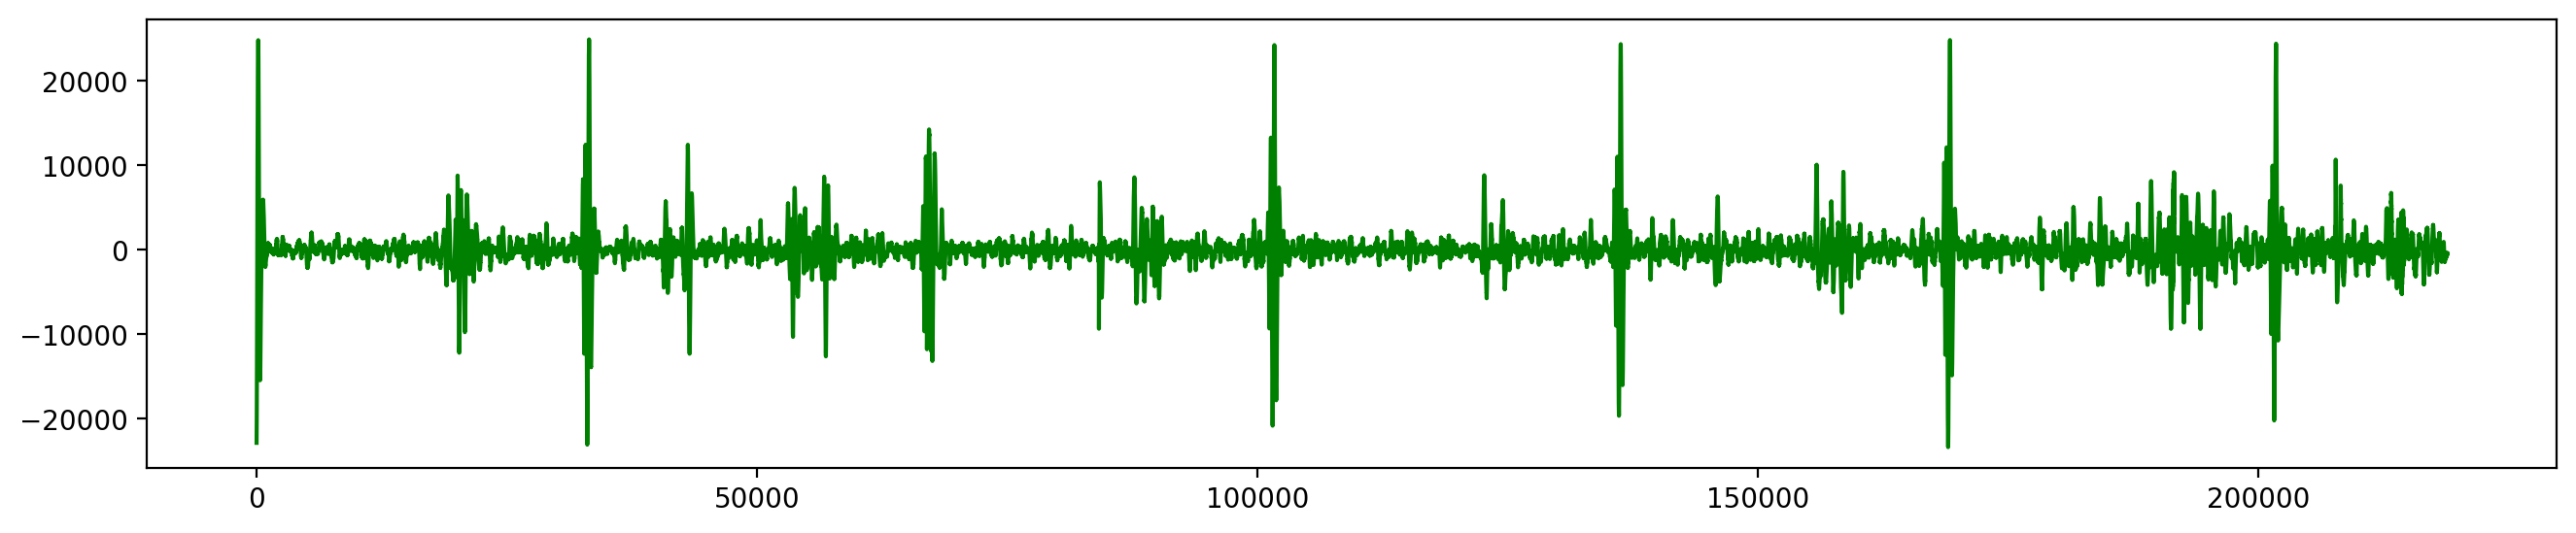

In [48]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', color="green");

In [49]:
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur = librosa.get_duration(y=y, sr=sr)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


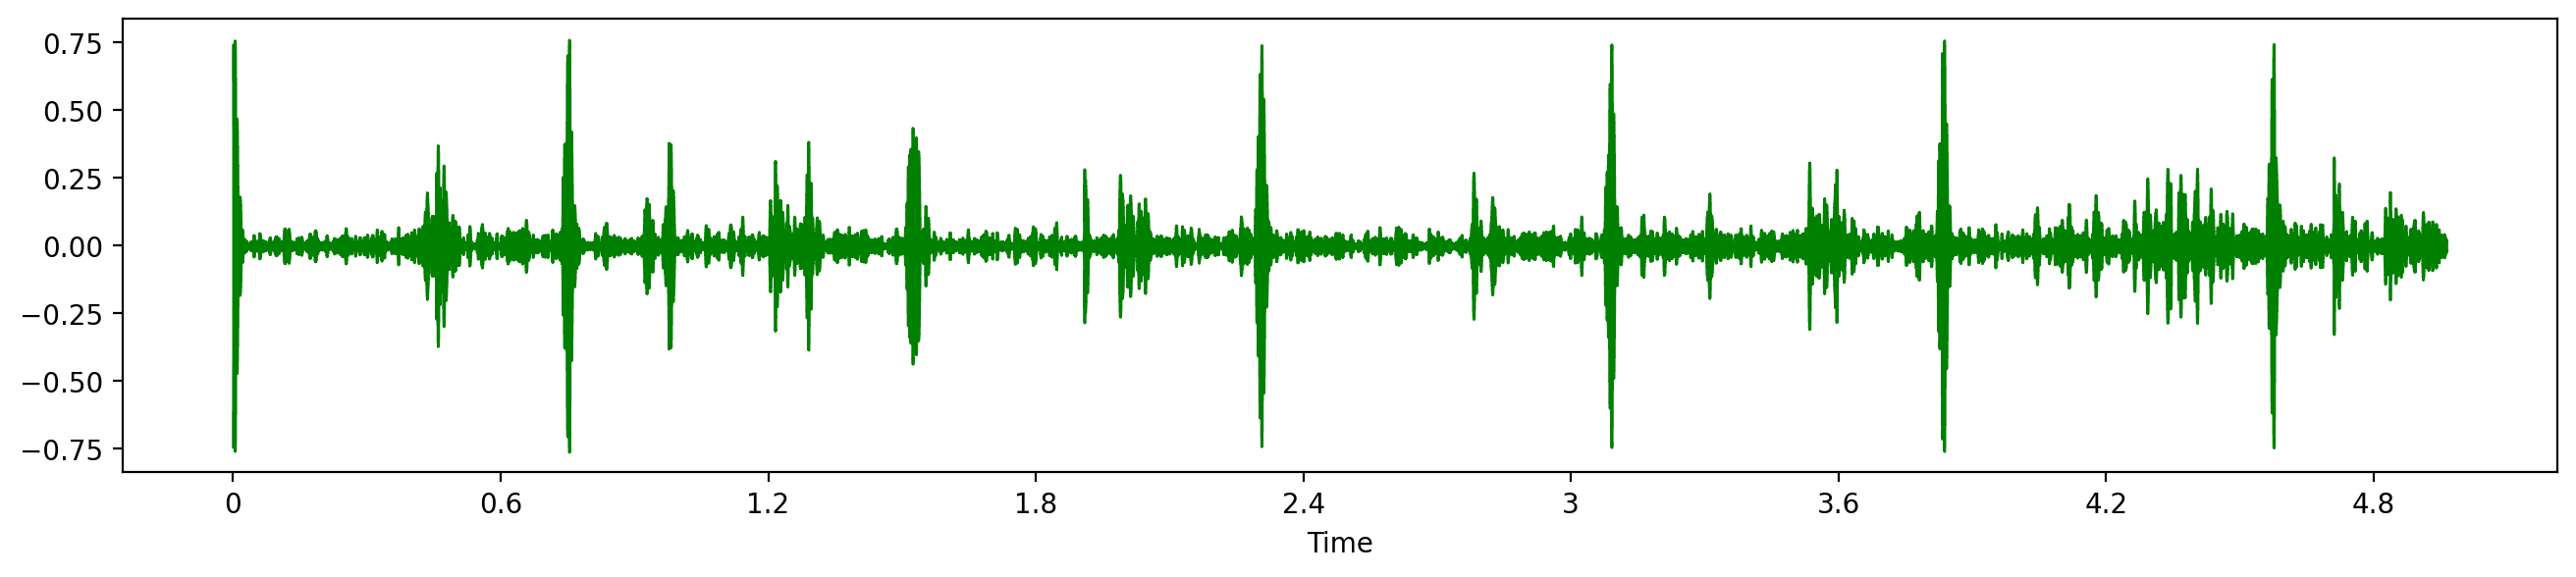

In [50]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr, color="green")

In [52]:
#2. Murmur
# murmur case
murmur_file=INPUT_DIR+"/set_app/murmur__201108222251.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [53]:
import IPython.display as ipd
ipd.Audio(murmur_file)

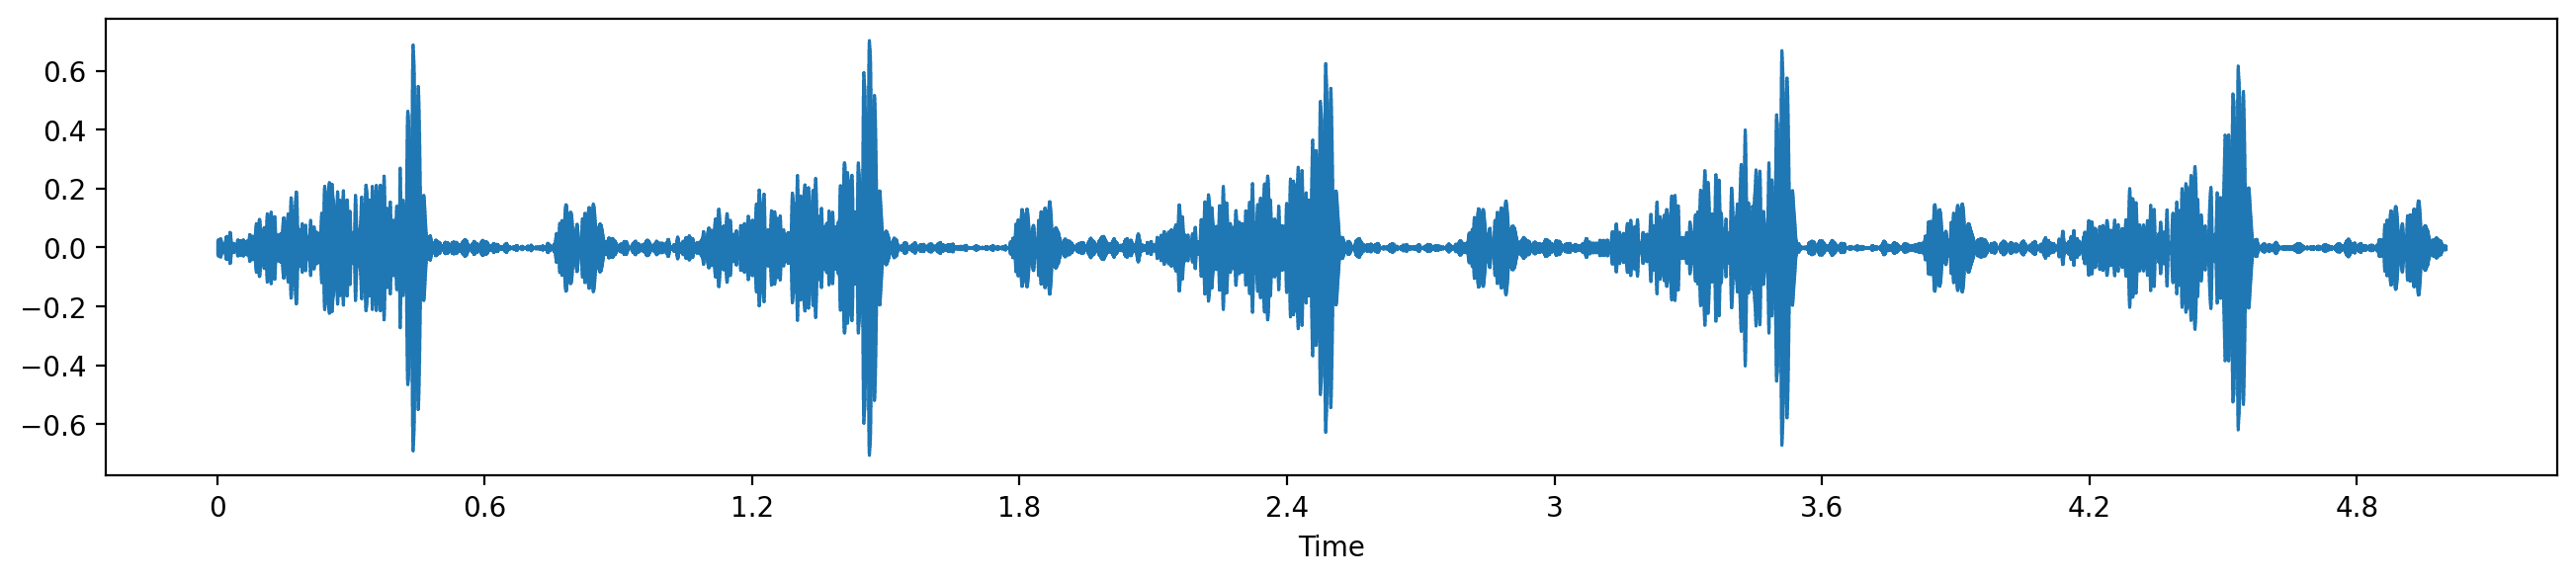

In [59]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y2, sr=sr2)

In [60]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_clinic/extrastole__261_1309353556003_C.wav"
y3, sr3 = librosa.load(extrastole_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y3.shape,sr3)

duration: 4.963809523809524
(110250,) 22050


In [61]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file)

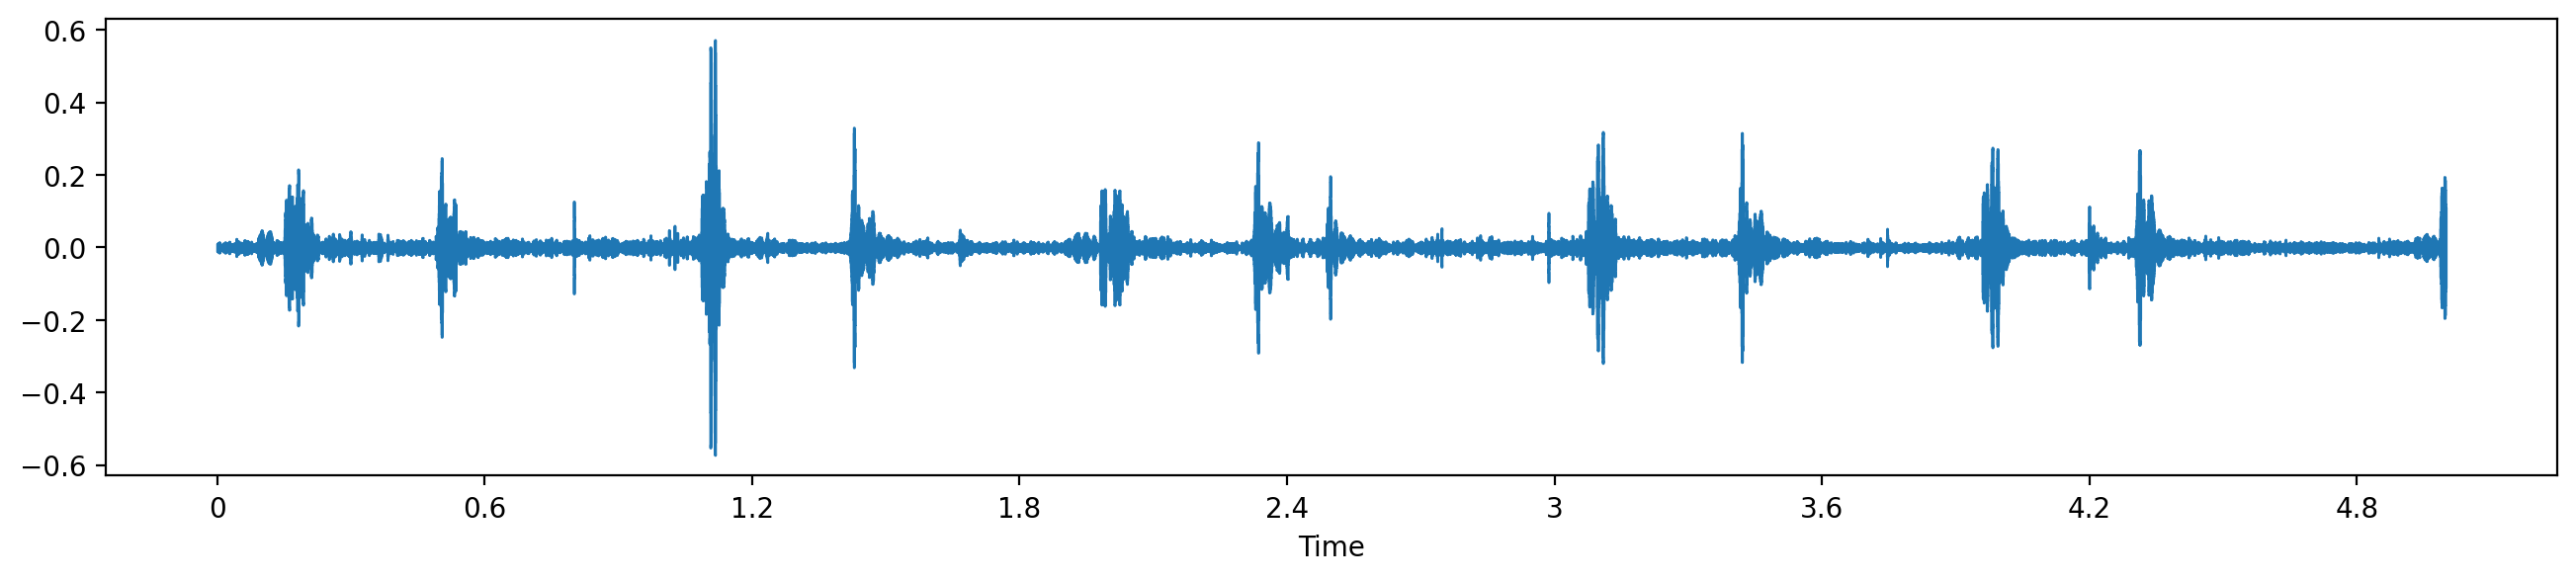

In [65]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y3, sr=sr3)